<a href="https://colab.research.google.com/github/rubyvanrooyen/astrokat/blob/rvr_more_user_notebooks/notebooks/check_HV_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime

# User input

In [ ]:
#@markdown Select polcal from dropdown list
polcal = '3C286' #@param ["3C48", "3C138", "3C286"]
#@markdown Center frequency in [MHz]
f_mhz = 1400.0 #@param {type:"number"}

#@markdown Observation date & time
date_input = '2021-07-25' #@param {type:"date"}
time_input = '00:00:00' #@param {type:"string"}

# MeerKAT polarisation calibrator

In [ ]:
# Listed coefficients from MeerKAT polcal catalogue
# name : Flux model (Min freq [MHz] Max freq [MHz] [model coefficients, MHz])
pol_flux = {"3C48 | J0137+3309":  # coeffs @ 2012 (TBL 11)
            {'ra': '01:37:41.2995',
             'dec': '33:09:35.134',
             'flux': np.array([50., 50000., 0.5240, 1.7377, -0.6396, 0.0498])},
            "3C138 | J0521+1638":  # coeffs @ 2012 (TBL 11)
            {'ra': '05:21:9.8860',
             'dec': '16:38:22.052',
             'flux': np.array([50., 50000., 1.3781, 0.1619, -0.0650, -0.0100])},
            "3C286 | J1331+3030":  # steady source (TBL 10)
            {'ra': '13:31:08.2881',
             'dec': '30:30:32.959',
             'flux': np.array([50., 50000., 0.0181, 1.5920, -0.5011, 0.0357])},
            }


In [ ]:
cal_list = list(pol_flux.keys())
cal_idx = np.flatnonzero(np.char.find(cal_list, polcal)!=-1)[0]
cal_key = cal_list[cal_idx]
ra = pol_flux[cal_key]['ra']
dec = pol_flux[cal_key]['dec']
pol_cal_model = pol_flux[cal_key]['flux']
# Flux density of calibrator over frequency using fitted coefficients
min_freq_mhz = pol_cal_model[0]
max_freq_mhz = pol_cal_model[1]
coeffs = pol_cal_model[2:]

In [ ]:
# make astropy friendly
[hh, mm, ss] = ra.split(':')
ra = f'{hh}h{mm}m{ss}s'
[dd, mm, ss] = dec.split(':')
dec = f'{dd}d{mm}m{ss}s'

[yy, mm, dd] = np.array(date_input.split('-'), dtype=int)
[hh, min, ss] = np.array(time_input.split(':'), dtype=int)
obs_time = datetime(year=yy, month=mm, day=dd, hour=hh, minute=min, second=ss)

# Flux density model

Refer to
[AstroKAT flux fit](https://github.com/ska-sa/astrokat/blob/master/notebooks/astrokat_fitflux.ipynb)
notebook for flux model calculation for MeerKAT telescope using
[Perley & Butler 2017](https://iopscience.iop.org/article/10.3847/1538-4365/aa6df9)
flux model coefficients
```
# Listed coefficients in GHz as per reference
# name : Flux model (Min freq [MHz] Max freq [MHz] [model coefficients, GHz])
pol_flux = {"3C48 | J0137+3309":  # coeffs @ 2012 (TBL 11)
            np.array([50., 50000., 1.3324, -0.7690, -0.1950, 0.059]),
            "3C138 | J0521+1638":  # coeffs @ 2012 (TBL 11)
            np.array([200., 50000., 1.0332, -0.5608, -0.1197, 0.041]),
            "3C286 | J1331+3030":  # steady source (TBL 10)
            np.array([50., 50000., 1.2512, -0.4605, -0.1715, 0.0336]),
            }
```

In [ ]:
[a, b, c, d] = coeffs

def calc_flux_density(coeffs, freq):
    """Calculate flux density from polynomial equation."""
    log10S = coeffs[0]
    for idx, coeff in enumerate(coeffs[1:]):
        log10S += coeff * (np.log10(freq)**(idx + 1))
    return log10S

# calculate flux density from polynomial equation
flux_model_str = ''
for cnt, coeff in enumerate([a, b, c, d]):
    sign = '+' if coeff > 0 else '-'
    if cnt < 1:
        flux_model_str = f'{coeff:.4f} '
    elif cnt < 2:
        flux_model_str += f'{sign} {np.abs(coeff):.4f}*log10({f_mhz}) '
    else:
        flux_model_str += f'{sign} {np.abs(coeff):.4f}*log10({f_mhz})**{cnt} '
flux = 10**calc_flux_density([a, b, c, d], f_mhz)
print(f'Freq range {min_freq_mhz} [MHz] - {max_freq_mhz} [MHz]')
print(f'Flux model log10(S) = {flux_model_str}')
print(f'Flux @ {f_mhz} [MHz] = {flux:.5} [Jy]')

Freq range 50.0 [MHz] - 50000.0 [MHz]
Flux model log10(S) = 0.0181 + 1.5920*log10(1400.0) - 0.5011*log10(1400.0)**2 + 0.0357*log10(1400.0)**3 
Flux @ 1400.0 [MHz] = 15.084 [Jy]


# Polarisation properties
Values used can be found in the
[Perley & Butler 2013](https://iopscience.iop.org/article/10.1088/0067-0049/206/2/16)
VLA polarization guide

In [ ]:
# Table 3 polarisation properties
freq_ghz = np.array([1.050, 1.450, 1.640, 1.950, 2.450, 2.950, 3.250, 3.750, 4.500, 5.000, 6.500, 7.250, 8.100, 8.800, 12.80, 13.70, 14.60, 15.50, 18.10, 19.00, 22.40, 23.30, 36.50, 43.50])
pol_prop = {"3C48 | J0137+3309":
            {'PA':np.array([25, 140, -5, -150, -120, -100, -92, -84, -75, -72, -68, -67, -64, -62, -62, -62, -63, -64, -66, -67, -70, -70, -77, -85]),  # position angle [deg]
             'frac':np.array([0.3, 0.5, 0.7, 0.9, 1.4, 2.0, 2.5, 3.2, 3.8, 4.2, 5.2, 5.2, 5.3, 5.4, 6.0, 6.1, 6.4, 6.4, 6.9, 7.1, 7.7, 7.8, 7.4, 7.5]),  # fractional polarisation [%]
             },
            "3C138 | J0521+1638":
            {'PA':np.array([-14, -11, -10, -10, -9, -10, -10, np.nan, -11, -11, -12, -12, -10, -8, -7, -7, -8, -9, -12, -13, -16, -17, -24, -27]),  # position angle
             'frac':np.array([5.6, 7.5, 8.4, 9.0, 10.4, 10.7, 10.0, np.nan, 10.0, 10.4, 9.8, 10.0, 10.4, 10.1, 8.4, 7.9, 7.7, 7.4, 6.7, 6.5, 6.7, 6.6, 6.6, 6.5]),  # fractional polarisation
             },
            "3C286 | J1331+3030":
            {'PA':np.array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35, 36, 36]),  # position angle
             'frac':np.array([8.6, 9.5, 9.9, 10.1, 10.5, 10.8, 10.9, 11.1, 11.3, 11.4, 11.6, 11.7, 11.9, 11.9, 11.9, 11.9, 12.1, 12.2, 12.5, 12.5, 12.6, 12.6, 13.1, 13.2]),  # fractional polarisation
             },
            }


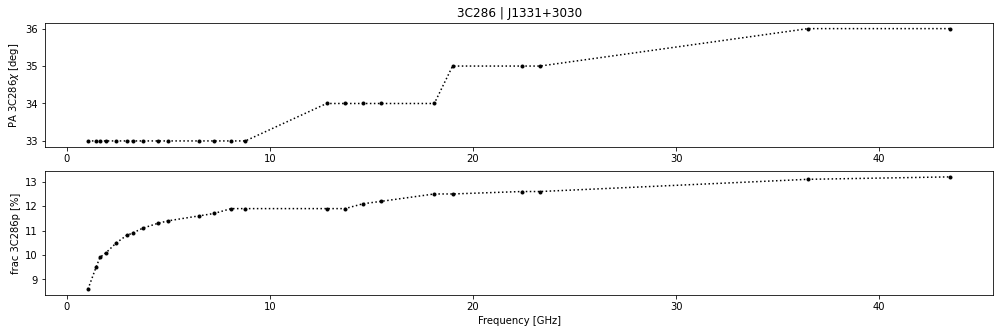

In [ ]:
cal_list = list(pol_prop.keys())
cal_idx = np.flatnonzero(np.char.find(cal_list, polcal)!=-1)[0]
cal_key = cal_list[cal_idx]
pol_cal_prob = pol_prop[cal_key]

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(17, 5), facecolor='white')
ax0.plot(freq_ghz, pol_cal_prob['PA'], 'k.:')
ax1.plot(freq_ghz, pol_cal_prob['frac'], 'k.:')
ax0.set_title(f'{cal_key}')
ax0.set_ylabel(r'PA {}$\chi$ [deg]'.format(polcal))
ax1.set_ylabel(r'frac {}p [%]'.format(polcal))
ax1.set_xlabel('Frequency [GHz]')
plt.show()

In [ ]:
def fit_poly(x, y, x0):
    if len(x) < 3: p_o = 1
    else: p_o = 2
    c2p = np.polyfit(x, y, p_o) 
    p2 = np.poly1d(c2p)
    return p2(x0)

f_ghz = f_mhz/1e3
idx_ = np.argmin(np.abs(freq_ghz - f_ghz))
# fit with a second degree polynomial
if idx_ > 0:
    x = freq_ghz[idx_-1:idx_+2]
else:
    x = freq_ghz[idx_:idx_+2]
y0 = pol_cal_prob['frac'][idx_-1:idx_+2]
pol_frac = fit_poly(x, y0, f_ghz)

y1 = pol_cal_prob['PA'][idx_-1:idx_+2]
pol_pa = fit_poly(x, y1, f_ghz)

print(f'Polarisation properties for {polcal}')
print(f'\t Fractional polarisation @ {f_mhz} [MHz] = {pol_frac:.4f} [%]')
print(f'\t Position angle @ {f_mhz} [MHz] = {pol_pa:.4f} [deg]')

Polarisation properties for 3C286
	 Fractional polarisation @ 1400.0 [MHz] = 9.3918 [%]
	 Position angle @ 1400.0 [MHz] = 33.0000 [deg]


# Parallactic angle

See notebook [PA_calculations.ipynb](https://colab.research.google.com/drive/1rLQJEg08q_Q-AVI6l8ET3moXDa7fwL1V?usp=sharing) for detail calculations

In [ ]:
from astropy.coordinates import Longitude, Latitude, EarthLocation
from astropy.coordinates import ICRS, FK5, SkyCoord, AltAz, SkyCoord
from astropy import coordinates as coord
from astropy import units as u
from astropy.time import Time

# reference position is given in geodetic coordinates (lat, lon, height)
astropy_telescope = EarthLocation.from_geodetic(Longitude('21:26:38.0', u.degree, wrap_angle=180. * u.degree, copy=False),
                                                Latitude('-30:42:39.8', u.degree, copy=False),
                                                height=u.Quantity(1086.6, u.m, copy=False))
obs_time = Time(obs_time, format='datetime', scale='utc', location=astropy_telescope)
observer = AltAz(location=astropy_telescope, obstime=obs_time)

# equatorial coordinates of sky target
target = SkyCoord(ra=ra, dec=dec, frame=FK5, equinox='J2000.0')
# recalculate for DATE-OBS (precession)
target = target.transform_to(FK5(equinox=obs_time))
altaz = target.transform_to(observer)  

HA = obs_time.sidereal_time('apparent') - target.ra.to(u.hourangle)
# PA formula from Astronomical Algorithms 
pa = np.arctan2(np.sin(HA.radian), np.cos(target.dec) *  np.tan(observer.location.lat) - np.sin(target.dec) * np.cos(HA.radian))

print(f'PA for target {polcal} @ {date_input}T{time_input} = {np.degrees(pa)}')

PA for target 3C286 @ 2021-07-25T00:00:00 = 106.26606996844205 deg


# HV power check

Refer to example GIST from Ben Hugo: https://gist.github.com/bennahugo/17e17956577580e25e5a42c54bd0da1c


In [ ]:
# --- DO NOT MOD BELOW THIS ---

# set these to which one of the calibrators you want to use
S_sel = flux
Pfraction_sel = pol_frac/100.
EVPA_sel =  np.radians(pol_pa)

# parallactic angle in radians
spa = pa.value
epa = pa.value

P = Pfraction_sel * np.exp(2.0j * EVPA_sel) # percent centre of band split into Q + iU
U = P.imag
Q = P.real
Qavail_s = Q * np.cos(2*spa) + U * np.sin(2*spa)
Uavail_s = U * np.cos(2*spa) - Q * np.sin(2*spa)
Qavail_e = Q * np.cos(2*epa) + U * np.sin(2*epa)
Uavail_e = U * np.cos(2*epa) - Q * np.sin(2*epa)

print(f"Max fractional linear power available on both hands: {Pfraction_sel * S_sel:.2f} Jy")
print(f"Max fractional HV power at {f_mhz/1e3:.1f}GHz: {max(np.abs(Uavail_s), np.abs(Uavail_e)) * 100.0:.2e}%")
print(f"S_{f_mhz/1e3:.1f} of selected calibrator: {S_sel:.2f} Jy")
print(f"Max HV power Jy at {f_mhz/1e3:.1f}GHz: {max(np.abs(Uavail_s), np.abs(Uavail_e)) * S_sel:.2e} Jy")

Max fractional linear power available on both hands: 1.42 Jy
Max fractional HV power at 1.4GHz: 5.18e+00%
S_1.4 of selected calibrator: 15.08 Jy
Max HV power Jy at 1.4GHz: 7.81e-01 Jy
